 ### Red and White Wine binary classification using Support Vector Machines, Random Forest, Gradient Boost

### Let’s first import all python-based libraries necessary to read the data, process it, and then perform further exploratory analysis on it: 

In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
%matplotlib inline

### Part 1: Data Reading, Preprocessing, and Exploratory Analysis

In [96]:
df = pd.read_csv('wine_dataset.csv')

In [97]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


### Data Summary

In [98]:
print("\nData Summary")
print(" ")
print ("Number of Rows     : " , df.shape[0])
print ("Number of Columns  : " , df.shape[1] ,"\n")
print ("\nFeatures : \n\n" , df.info(),"\n", df.describe())
print ("\nMissing values:\n\n",df.isnull().sum())
print ("\nUnique values :  \n\n",df.nunique())



Data Summary
 
Number of Rows     :  6497
Number of Columns  :  13 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  style                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660

#### The ‘style’ feature contains ‘white’ or ‘red’, and is therefore classified as ‘object’ type. 
#### Let’s convert our ‘style’ feature into a numeric one so that our algorithms can understand the underlying types as well:

In [99]:
df['target']=np.where(df['style']=='white', 1, 0)

In [100]:
df['target']

0       0
1       0
2       0
3       0
4       0
       ..
6492    1
6493    1
6494    1
6495    1
6496    1
Name: target, Length: 6497, dtype: int32

#### Find the ‘input’ features which form the best correlation with the ‘output’ variable:

In [101]:
df.corr()['target'].sort_values(ascending=True)

volatile_acidity       -0.653036
chlorides              -0.512678
sulphates              -0.487218
fixed_acidity          -0.486740
density                -0.390645
pH                     -0.329129
alcohol                 0.032970
quality                 0.119323
citric_acid             0.187397
residual_sugar          0.348821
free_sulfur_dioxide     0.471644
total_sulfur_dioxide    0.700357
target                  1.000000
Name: target, dtype: float64

#### It seems like ‘volatile acidity’, ‘chlorides’, ‘sulphates’ and ‘fixed_acidity’ form the negative correlation, whereas ‘free_sulfur_dioxide’ and ‘total_sulfur_dioxide’ form the best positive correlation with the ‘target’ value.

#### Now draw a pair plot for all the input features and try to spot any more patterns among the data:

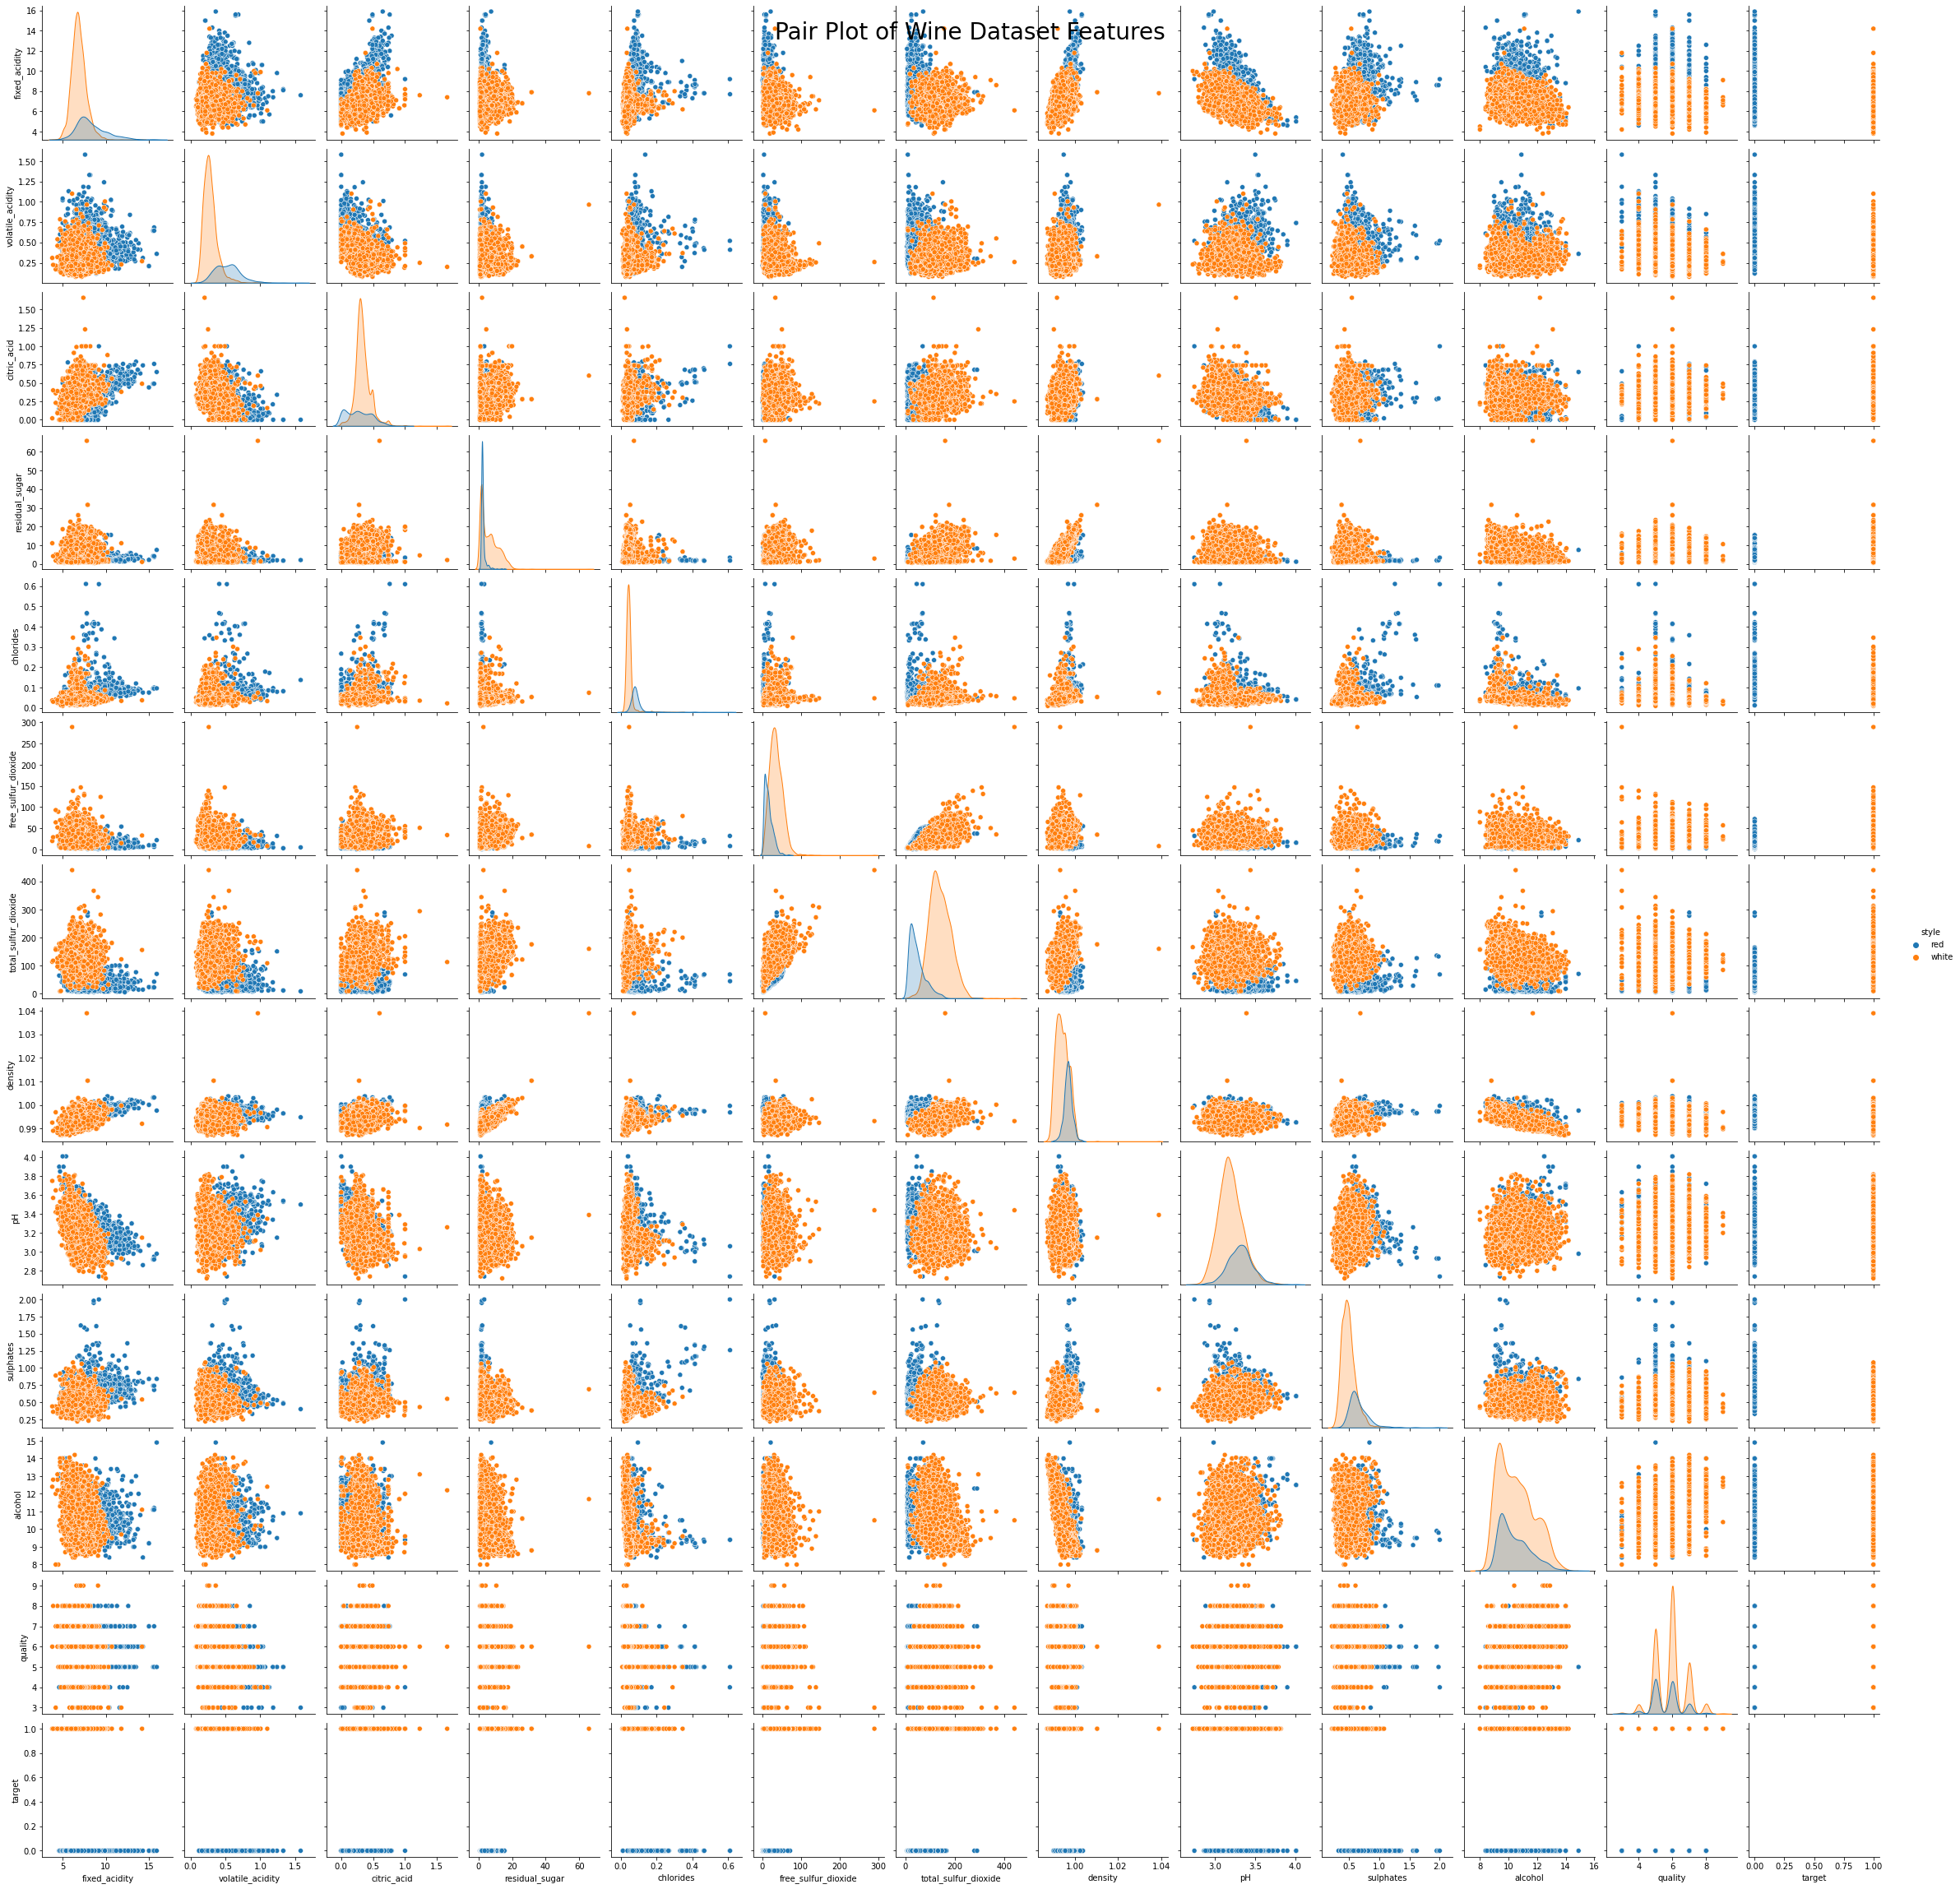

In [102]:
sns.pairplot(df, hue='style')
plt.suptitle('Pair Plot of Wine Dataset Features', 
             size = 28);

#### Lets look at the numeric correlation values between each numeric feature using SNS heatmap:

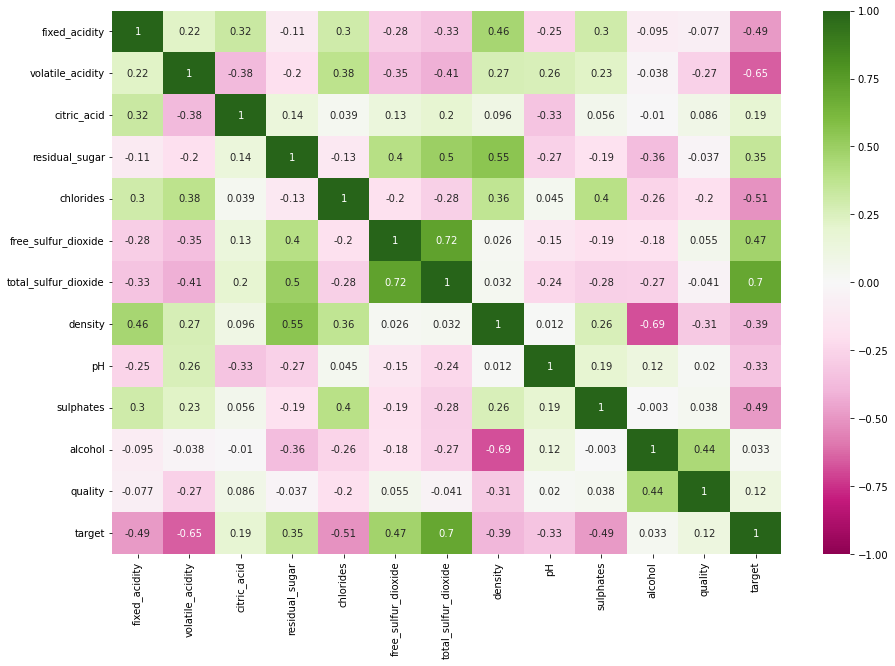

In [103]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='PiYG')
plt.show()

#### Here are some salient patterns which I have spotted just by looking at the above two plots:

#### Free Sulfur Dioxide and Total Sulfur Dioxide are positively correlated i.e., if you have more of one, you will have more of the other
#### Density and Alcohol exhibit a reciprocal relationship i.e., more the concentration of alcohol, less the density
#### Density exhibits a positive correlation with the Fixed Acidity and Residual Sugar
#### Quality is also positively linked with the amount of Alcohol i.e., more alcohol a wine has, the more its perceived quality. 
#### Volatile Acidity depicts a negative correlation with the Total Sulfur Dioxide

#### The above relationships are visually plotted as follows:
####  Relation between highly correlated features of Wine Dataset

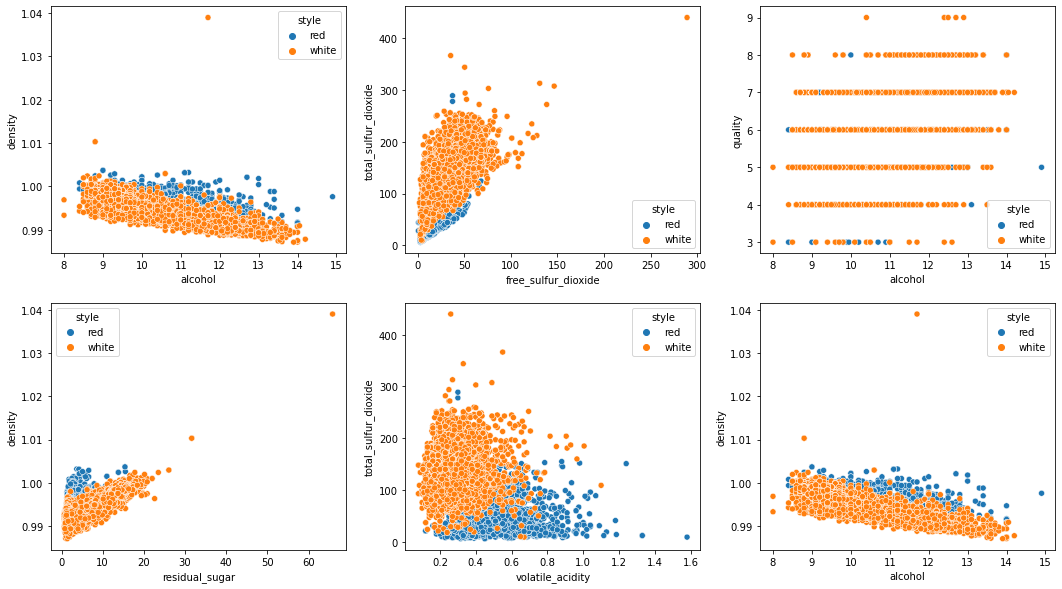

In [104]:
fig, axes = plt.subplots(2,3, figsize=(18,10))
sns.scatterplot(data=df, x='alcohol', y='density', hue='style', ax=axes[0, 0])
sns.scatterplot(data=df, x='free_sulfur_dioxide', y='total_sulfur_dioxide', hue='style', ax=axes[0, 1])
sns.scatterplot(data=df, x='alcohol', y='quality', hue='style', ax=axes[0, 2])
sns.scatterplot(data=df, x='residual_sugar', y='density', hue='style', ax=axes[1, 0])
sns.scatterplot(data=df, x='volatile_acidity', y='total_sulfur_dioxide', hue='style', ax=axes[1, 1])
sns.scatterplot(data=df, x='alcohol', y='density', hue='style', ax=axes[1, 2])
plt.show()

 ####       Let’s now explore the relation between the input features and the output class. To keep things clean, I will only plot the Kernel Density Estimation of the most important features differentiated by the target style:      
 
 #### Relation between Input Features and Output Class for Wine Dataset

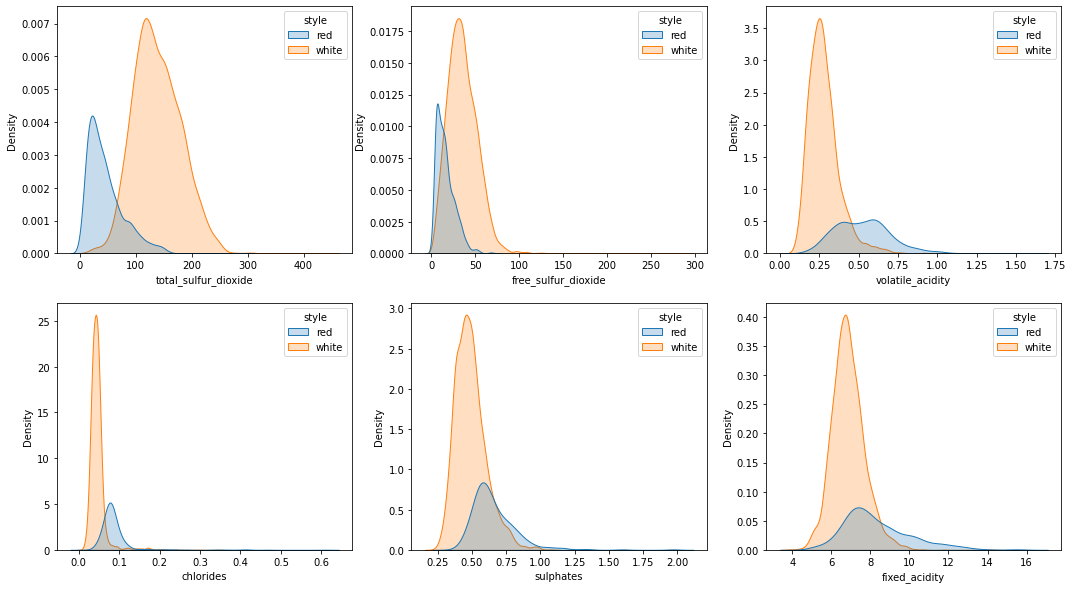

In [105]:
fig, axes = plt.subplots(2,3, figsize=(18, 10))
sns.kdeplot(data=df, x='total_sulfur_dioxide', hue='style', shade='style', ax=axes[0, 0])
sns.kdeplot(data=df, x='free_sulfur_dioxide', hue='style', shade='style', ax=axes[0, 1])
sns.kdeplot(data=df, x='volatile_acidity', hue='style', shade='style', ax=axes[0, 2])
sns.kdeplot(data=df, x='chlorides', hue='style', shade='style', ax=axes[1, 0])
sns.kdeplot(data=df, x='sulphates', hue='style', shade='style', ax=axes[1, 1])
sns.kdeplot(data=df, x='fixed_acidity', hue='style', shade='style', ax=axes[1, 2])
plt.show()

### Looking at the KDE plots of these features, following salient points could be noted down:

#### All the features are, more or less, normally distributed
#### The feature distribution for the ‘Red’ class is right-skewed
#### Density of the ‘White’ wine samples is larger than those of ‘Red’ wine which depicts that majority of the wine samples correspond to ‘White’ wine
#### Distribution values for Total Sulfur Dioxide, Volatile Acidity, and Chlorides are significantly different for both the wines and can greatly impact the performance of binary classification models

#### Now let’s do some pre-processing on the data before we can move onto building the binary classification models using machine learning algorithms.

### Data Pre-processing

#### Firstly, drop the ‘style’ feature from the data set as we have already substituted its ‘object’ values into ‘numeric’ ones via ‘target’ feature:

In [106]:
df.drop('style', axis=1, inplace=True)

#### Specifed a uniform datatype for all the features, and separate the Input features of the data from its output style:

In [107]:
df = df.astype('float32')
data_X = df.drop('target', axis=1)
data_y = df['target']


#### Split the dataset into Training Data (75%) and Testing Data (25%). Training data will be used by the models for training, whereas Testing Data will be used to gauge the performance of the trained models on the unseen data.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=1)

#### Since the input features are numeric and differ in individual scales, they need to be scaled such that the distribution of each feature will have mean=0, and std=1.

#### StandardScaler() is the industry’s go-to algorithm to perform such scaling, which in-turn, enhances the training capability of the mathematical machine learning models as they need to evaluate each feature having the approx. same distribution.

In [109]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### We only need to fit the StandardScaler() on the Training Data and not the Testing Data, since the fitting of scaler on the Testing Data will lead to data leakage.

#### After the necessary pre-processing, let’s build our first multi-class training model using Support Vector Machine (SVM) and evaluate its performance…

### Part 2: White and Red Wine Classification using Support Vector Machines

#### To train the SVM model on the Wine data set, Support Vector Classifier (SVC) is employed from scikit-learn library. At first, SVC() model is fitted on the training data with default parameters:

In [110]:
svm_model = SVC(C=1, kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=1)

#### ‘C’ is the regularization parameter which controls underfitting/overfitting. Higher value of ‘C’ leads to less regularization which results in overfitting and vice versa.

#### ‘Kernel’ is selected based on the shape/dimension of the input features. Other values could be ‘linear’, ‘poly’ or ‘sigmoid’.

#### Once the model is trained, we need to predict the performance of the model on the testing data set:

In [111]:
svm_y_pred = svm_model.predict(X_test)
print('Accuracy Score', accuracy_score(y_test, svm_y_pred))
print('\n Confusion Matrix\n', confusion_matrix(y_test, svm_y_pred))
print('\n Classification Report\n', classification_report(y_test, svm_y_pred))

Accuracy Score 0.9944615384615385

 Confusion Matrix
 [[ 376    6]
 [   3 1240]]

 Classification Report
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       382
         1.0       1.00      1.00      1.00      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



#### So, we have got almost perfect accuracy, recall, and precision scores. 

#### Let’s now tune hyper-parameters for SVM and evaluate whether we can further enhance the performance of the SVM binary classification model.

#### Hyperparameter tuning for SVM
#### In this alternative approach, we will train the model using a subset of hyperparameters and then select best parameters based on a scoring metric i.e., accuracy:

In [112]:
svm_param_grid = {'C':[0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf'],
                'gamma' :[0.001, 0.01, 0.1, 1, 10]}
svm_cv = StratifiedKFold(n_splits=5)
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=svm_cv, scoring='accuracy')
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

#### SVC() model will be trained using each combination of the hyperparameters specified in ‘svm_param_grid’.

#### During each iteration, model will be trained using 5-fold cross-validation. 4-folds of the data will be used to train the model, and remaining fold will be used to test the accuracy of the trained model.

#### Also note that we are using ‘StratifiedKFold’ here instead of the legendary ‘Kfold’. The main reason being that White (4898) and Red Wine (1599) samples are not distributed equally in the data set. When making folds during cross validation, ‘StratifiedKFold’ will ensure that fold consists of the same ratio of the white and red wine samples as that of the original dataset.

#### Hyperparameters resulting in the maximum accuracy will be used to train the model on the complete dataset in the final stages of ‘GridSearchCV’.

#### We can get the parameters which resulted in the maximum accuracy as follows:

In [113]:
print('SVM Best Params:', svm_grid.best_params_)
print('SVM Best Score:', svm_grid.best_score_)

SVM Best Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Best Score: 0.9969201284683831


In [114]:
svm_y_pred = svm_grid.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, svm_y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, svm_y_pred))
print('\nClassification Report:\n', classification_report(y_test, svm_y_pred))

Accuracy Score: 0.9944615384615385

Confusion Matrix:
 [[ 376    6]
 [   3 1240]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       382
         1.0       1.00      1.00      1.00      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



#### So, we did improve our accuracy a little bit with the optimized hyperparameters for the support vector machines.

#### Let’s now train Random Forest Classifier model on the same data set…

### Data Classification using Random Forest Classifier

#### Random Forest Classifier is basically a lot of decision tree classifiers combining to give the majority vote in favor of a class. we can train a Random Forest classifier using scikit-learn library in Python:

### Part 3: Red and White wine data classification using Random Forest Classifier

In [115]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

#### ‘n_estimators’ specify the number of decision trees which will be used to train the Random Forest classifier.

#### Let’s observe the accuracy of the Random Forest model on the test data set:

In [116]:
rf_y_pred = rf_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, rf_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, rf_y_pred))
print('\n Classification Report:\n', classification_report(y_test, rf_y_pred))

Accuracy Score: 0.992

 Confusion Matrix:
 [[ 372   10]
 [   3 1240]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       382
         1.0       0.99      1.00      0.99      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Hyperparameter tuning for Random Forest

#### Similar to what we did for the SVM model, we will tune the hyperparameters of the Random Forest Classifier using 5-fold cross-validation via GridSearchCV() and StratifiedKFold():

In [117]:
rf_param_grid = {'max_samples': [0.1, 0.2, 0.3, 0.4],
                'max_features': [5, 6, 7],
                'n_estimators' :[50, 100, 500, 1000],
                'max_depth': [10, 11, 12]
                }
rf_cv = StratifiedKFold(n_splits=5)
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=rf_cv)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 11, 12], 'max_features': [5, 6, 7],
                         'max_samples': [0.1, 0.2, 0.3, 0.4],
                         'n_estimators': [50, 100, 500, 1000]})

#### ‘max_samples’ denote the fraction of the total samples which all the decision trees will use to specify the individual contribution.

#### Since there are only 12 input features in the  dataset, we will specify a max feature set to be ‘5’, ‘6’ or ‘7’ for more robust model training.

#### ‘max_depth’ denotes the maximum depth of the decision steps for each individual decision tree in the Random Forest model.

#### After the model is trained, you can get the best model parameters as well as evaluate the performance of the trained model on the test data set:

In [118]:
print('RF best Parameters:', rf_grid.best_estimator_)
print('RF best Score:', rf_grid.best_score_)

RF best Parameters: RandomForestClassifier(max_depth=10, max_features=5, max_samples=0.4,
                       n_estimators=50)
RF best Score: 0.9940472805770547


#### Let’s evaluate the performance of the optimized Random Forest model:

In [119]:
rf_y_pred = rf_grid.predict(X_test)
print('Accuracy:', accuracy_score(y_test, rf_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, rf_y_pred))
print('\n Classification Report:\n', classification_report(y_test, rf_y_pred))

Accuracy: 0.9907692307692307

 Confusion Matrix:
 [[ 374    8]
 [   7 1236]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       382
         1.0       0.99      0.99      0.99      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Data Classification using Gradient Boosting Classifier

#### Gradient Boosting classifier is a combined sequential model of various Decision Trees, where the outcome of one decision tree is used to train the next one and so on.

#### ‘learning_rate’ will specify how much impact outcome of one tree has on the next one. You can control underfitting/overfitting of the gradient boosting classifier using ‘learning_rate’ of the model.

### Part 4: Red and White wine data classification using Gradient Boosting Classifier

In [120]:
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500)

#### ‘n_estimators’ specify the number of decision trees to be employed in training the gradient boosting classifier.

In [121]:
gb_y_pred  = gb_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, gb_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, gb_y_pred))
print('\n Classification Report:\n', classification_report(y_test, gb_y_pred))

Accuracy Score: 0.9926153846153846

 Confusion Matrix:
 [[ 374    8]
 [   4 1239]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       382
         1.0       0.99      1.00      1.00      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Hyperparameter tuning for Gradient Boosting Classifier
#### Tuning the hyperparameters for this classifier is more or less similar to that of Random Forest Classifier:

In [122]:
gb_grid_param = {'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators' : [10, 50, 100],
                'max_depth': [10, 11, 12],
                'max_features': [5, 6, 7]}
gb_cv = StratifiedKFold(n_splits=5)
gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_grid_param, cv=gb_cv)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 11, 12], 'max_features': [5, 6, 7],
                         'n_estimators': [10, 50, 100]})

#### Best parameters and performance of the gradient boosting classifier on the testing set can be evaluated as follows:




In [123]:
print('GB best Parameters:', gb_grid.best_estimator_)
print('GB best Score:', gb_grid.best_score_)

GB best Parameters: GradientBoostingClassifier(max_depth=10, max_features=5)
GB best Score: 0.9965100826620332


In [124]:
gb_y_pred = gb_grid.predict(X_test)
print('Accuray:', accuracy_score(y_test, gb_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, gb_y_pred))
print('\n Classification Report:\n', classification_report(y_test, gb_y_pred))

Accuray: 0.992

 Confusion Matrix:
 [[ 372   10]
 [   3 1240]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       382
         1.0       0.99      1.00      0.99      1243

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



### Important Features of Wine Data
#### Previously, we have trained our classification models using the full feature set of the wine data set which is acceptable in some cases. However, most of the times, we need to only consider the features which play a significant role in identifying the target values and then train the models using such features.

#### This has a larger impact of reducing the training time as well as the consumption of computation resources. As we have already entered the regime of Cloud based distributed training platforms, the need for identifying the most relevant features out of the feature set is a critical requirement.

#### For our dataset, we have already identified the critical features during exploratory data analysis i.e., "total_sulfur_dioxide", "volatile_acidity", "chlorides", "sulphates", "fixed_acidity", "free_sulfur_dioxide".

#### Let’s now extract a dataset consisting of these features only:

### Part 5:  Selecting the Important Features in the Dataset

In [125]:
features = ["total_sulfur_dioxide", "volatile_acidity", "chlorides", "sulphates", "fixed_acidity", "free_sulfur_dioxide"]
data_X = df[features]
data_y = df['target']

#### Split the data into Training (75%) and Testing (25%) instances, and standardize the input ‘numeric’ features:

In [126]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part 6:Training the ML Models based on their optimized parameters on the selected feature set

### Binary Classification using the Important Features

#### We will now train the machine learning models on this stripped-down data set, and compare their performance with the models trained on the full-fledged feature set.

#### So, let’s start with the support vector machines (SVM)…

### Support Vector Machine (SVM) Training

#### Specify the features of the SVM model which were obtained after hyper-parameter tuning, and let the model train on the new feature set:

In [127]:
svm_model = SVC(C = 10, gamma = 0.01, kernel='rbf')
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, svm_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, svm_y_pred))
print('\n Classification Report:\n', classification_report(y_test, svm_y_pred))

Accuracy Score: 0.9815384615384616

 Confusion Matrix:
 [[ 369   13]
 [  17 1226]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       382
         1.0       0.99      0.99      0.99      1243

    accuracy                           0.98      1625
   macro avg       0.97      0.98      0.97      1625
weighted avg       0.98      0.98      0.98      1625



#### Full-Feature SVM Model Accuracy: 0.994

#### Important-Features SVM Model Accuracy: 0.982

#### So, we have got almost similar accuracy with almost half the features.

### Random Forest Classifier Training
#### Specify the parameters of the Random Forest model obtained after hyperparameter optimization, and train the model on the important features:

In [128]:
rf_model = RandomForestClassifier(max_depth=10, max_features=6, max_samples=0.4, n_estimators=50)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, rf_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, rf_y_pred))
print('\n Classification Report:\n', classification_report(y_test, rf_y_pred))

Accuracy Score: 0.9815384615384616

 Confusion Matrix:
 [[ 368   14]
 [  16 1227]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       382
         1.0       0.99      0.99      0.99      1243

    accuracy                           0.98      1625
   macro avg       0.97      0.98      0.97      1625
weighted avg       0.98      0.98      0.98      1625



#### Full-Feature Random Forest Model Accuracy: 0.990

#### Important-Features Random Forest Model Accuracy: 0.983

#### So, we have got almost similar accuracy. 

### Gradient Boosting Classifier Training
#### Train the model using the best parameters obtained after hyperparameter optimization, and evaluate the performance of the model on the testing data set:



In [129]:
gb_model = GradientBoostingClassifier(learning_rate=0.001, n_estimators=10, max_depth=10, max_features=5)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, gb_y_pred))
print('\n Confusion Matrix:\n', confusion_matrix(y_test, gb_y_pred))
print('\n Classification Report:\n', classification_report(y_test, gb_y_pred))

Accuracy Score: 0.7649230769230769

 Confusion Matrix:
 [[   0  382]
 [   0 1243]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       382
         1.0       0.76      1.00      0.87      1243

    accuracy                           0.76      1625
   macro avg       0.38      0.50      0.43      1625
weighted avg       0.59      0.76      0.66      1625



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Full-Feature Random Forest Model Accuracy: 0.993

#### Important-Features Random Forest Model Accuracy: 0.988

#### Gradient Boosting classifier also seems to train the model well even when half the features are stripped off. 

### Conclusion
#### So we developed Support Vector Machine, Random Forest and Gradient Boost classification models for style wine data set. These classification models helped us identify the Red and White wine types using numeric input features. The hyperparameters of all the models were also tuned to optimize the performance of the classification model for all the algorithms.

#### Moreover, the models were trained using the more correlated features of the data set (6 features) and their performance was almost same when compared with the models developed using the full-fledge feature set (12 features). These results depicted that robust model could be trained using the important features only, which is a critical requirement to save computation resources as well as the training time.

#### Models were trained on the training data (75%), and their performance was evaluated using testing data (25%). Approx. accuracy of 99% showed that all of the trained models were able to differentiate the Red Wine from the White Wine.

## Thank You 